<a href="https://colab.research.google.com/github/camilouribeg/AT3-DL-image-captioning/blob/main/Amal_Experiment_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

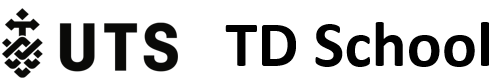


**Assessment 3: Image Captioning Project**

**94691 – Deep Learning Autumn 2025**

Experiment Amal Almaawadh - 24901098

## Google Colab Settings

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change working directory
import os
project_path = '/content/drive/MyDrive/Colab Notebooks/DL_Assignment3'
os.chdir(project_path)

In [3]:
%ls

'Colab Notebooks'@   data/   notebooks/   README.md   requirements.txt   utils/


## Import Libraries

In [4]:
# Project Imports
import sys
sys.path.append("..")   # so `utils/` is importable

import json
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torchvision.models as models
from torch.utils.data import DataLoader

from utils.dataloader import get_transforms, load_split_ids, build_caption_dataset
from utils.caption_dataset import CaptionDataset
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

In [5]:
#Add utils to path to import project modules
import sys
sys.path.append('utils')

In [6]:
from utils.dataloader import get_transforms, load_split_ids, build_caption_dataset
from utils.caption_dataset import CaptionDataset

In [7]:
# Confirm if the class was imported
print(CaptionDataset)

<class 'utils.caption_dataset.CaptionDataset'>


## Load Datasets

In [8]:
# Load vocabulary

processed_path = os.path.join(project_path, 'data', 'processed')

# Load vocabulary
with open(os.path.join(processed_path, 'word2idx.json'), 'r') as f:
    word2idx = json.load(f)

# Load image-caption sequences
with open(os.path.join(processed_path, 'image_caption_seqs.pkl'), 'rb') as f:
    image_caption_seqs = pickle.load(f)

In [9]:
# Load official splits

train_ids = load_split_ids(os.path.join(project_path, 'data', 'Flickr8k_text', 'Flickr_8k.trainImages.txt'))
val_ids   = load_split_ids(os.path.join(project_path, 'data', 'Flickr8k_text', 'Flickr_8k.devImages.txt'))
test_ids  = load_split_ids(os.path.join(project_path, 'data', 'Flickr8k_text', 'Flickr_8k.testImages.txt'))


## Data Preprocesing (Just Images)

In [10]:
# Set image folder path

image_folder = os.path.join(project_path, 'data', 'Flicker8k_Dataset')

# Define transforms
transform_train = get_transforms("train")
transform_val   = get_transforms("val")

# Build datasets using shared util function
train_dataset = build_caption_dataset(train_ids, image_caption_seqs, word2idx, image_folder, transform_train)
val_dataset   = build_caption_dataset(val_ids, image_caption_seqs, word2idx, image_folder, transform_val)
test_dataset  = build_caption_dataset(test_ids, image_caption_seqs, word2idx, image_folder, transform_val)

## Experiment Architecture

In [11]:
# Encoder: ResNet-101 + Flatten to (B, N, C)
class EncoderResNet101(nn.Module):
    def __init__(self, encoded_size=14, fine_tune=False):
        super().__init__()
        # 1) Load pretrained ResNet-101
        resnet = models.resnet101(pretrained=True)
        # 2) Drop the avgpool & fc layers
        modules = list(resnet.children())[:-2]
        self.backbone = nn.Sequential(*modules)
        # 3) Our own adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_size, encoded_size))
        # 4) Freeze if not fine-tuning
        if not fine_tune:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, images):
        # images: (B, 3, H, W)
        x = self.backbone(images)               # → (B, 2048, Hf, Wf)
        x = self.adaptive_pool(x)               # → (B, 2048, enc, enc)
        B, C, H, W = x.size()
        return x.view(B, C, H * W).permute(0, 2, 1)  # → (B, N=H*W, C)

In [12]:
# Decoder: GRU + Bahdanau Attention
class DecoderGRUWithBahdanau(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 encoder_dim=512, dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        # attention: score = v^T tanh(W_h h + W_e e)
        self.attn      = nn.Linear(hidden_dim + encoder_dim, hidden_dim)
        self.attn_v    = nn.Linear(hidden_dim, 1, bias=False)
        self.gru       = nn.GRU(embed_dim + encoder_dim, hidden_dim, batch_first=True)
        self.fc_out    = nn.Linear(hidden_dim, vocab_size)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, encoder_seq, captions):
        """
        encoder_seq: (B, N, encoder_dim)
        captions:    (B, T)
        """
        B, N, _ = encoder_seq.size()
        T = captions.size(1)
        embeddings = self.embed(captions)            # (B, T, E)
        hidden = torch.zeros(1, B, self.gru.hidden_size,
                             device=encoder_seq.device)
        outputs = []

        for t in range(T):
            # ——— Bahdanau Attention ———
            # expand hidden to (B, N, H)
            h_exp = hidden.permute(1, 0, 2).expand(B, N, -1)
            # concat [h_exp, encoder_seq] → (B, N, H+E)
            attn_in = torch.cat([h_exp, encoder_seq], dim=2)
            energy  = torch.tanh(self.attn(attn_in))       # (B, N, H)
            scores  = self.attn_v(energy).squeeze(2)       # (B, N)
            alpha   = torch.softmax(scores, dim=1).unsqueeze(2)  # (B, N, 1)
            # context vector
            context = (encoder_seq * alpha).sum(dim=1)     # (B, E)

            # ——— GRU step ———
            inp = torch.cat([embeddings[:, t, :], context], dim=1).unsqueeze(1)  # (B,1,E+E)
            out, hidden = self.gru(inp, hidden)           # out: (B,1,H)
            out = self.dropout(out.squeeze(1))            # (B, H)
            out = self.fc_out(out)                        # (B, V)
            outputs.append(out)

        # stack → (B, T, V)
        return torch.stack(outputs, dim=1)


In [13]:
# Wrap encoder+decoder in a single module
class CaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        enc_seq = self.encoder(images)        # (B, N, C_e)
        return self.decoder(enc_seq, captions)  # (B, T, V)


In [14]:
# Function for training the model

def train_model(model, train_dataset, val_dataset, word2idx,
                device='cuda', batch_size=32, epochs=20,
                patience=3, lr=1e-4):
    pad_idx = word2idx['<pad>']
    vocab_size = len(word2idx)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=2, factor=0.5
    )

    train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4,       # parallel data loading
    pin_memory=True      # faster host→GPU copies
    )
    val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
    )

    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, epochs+1):
        # ——— Training ———
        model.train()
        train_losses = []
        for images, captions, _ in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
            # ----- CLAMP ANY INVALID TOKEN IDS -----
            max_id = captions.max().item()
            if max_id >= vocab_size:
                # replace all OOB ids with the pad token
                captions = torch.where(
                    captions >= vocab_size,
                    torch.full_like(captions, pad_idx),
                    captions
                )
            # ---------------------------------------
            images   = images.to(device,   non_blocking=True)
            captions = captions.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                captions[:, 1:].reshape(-1)
            )
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # ——— Validation ———
        model.eval()
        val_losses, refs, hyps = [], [], []
        for images, captions, _ in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            # ----- CLAMP HERE AS WELL -----
            max_id = captions.max().item()
            if max_id >= vocab_size:
                captions = torch.where(
                    captions >= vocab_size,
                    torch.full_like(captions, pad_idx),
                    captions
                )
            # --------------------------------
            images, captions = images.to(device), captions.to(device)

            outputs = model(images, captions[:, :-1])
            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                captions[:, 1:].reshape(-1)
            )
            val_losses.append(loss.item())

            preds = torch.argmax(outputs, dim=2)
            for ref, pred in zip(captions, preds):
                ref_tokens  = [w for w in ref.tolist()
                               if w not in {pad_idx, word2idx['<start>'], word2idx['<end>']}]
                pred_tokens = [w for w in pred.tolist()
                               if w not in {pad_idx, word2idx['<start>'], word2idx['<end>']}]
                refs.append([ref_tokens])
                hyps.append(pred_tokens)

        avg_train = np.mean(train_losses)
        avg_val   = np.mean(val_losses)
        scheduler.step(avg_val)

        bleu1 = corpus_bleu(refs, hyps, weights=(1,0,0,0))
        bleu2 = corpus_bleu(refs, hyps, weights=(0.5,0.5,0,0))
        bleu3 = corpus_bleu(refs, hyps, weights=(0.33,0.33,0.33,0))
        bleu4 = corpus_bleu(refs, hyps, weights=(0.25,0.25,0.25,0.25))

        print(f"\nEpoch {epoch}: Train Loss={avg_train:.4f}, Val Loss={avg_val:.4f}")
        print(f"BLEU-1={bleu1:.4f}, BLEU-2={bleu2:.4f}, BLEU-3={bleu3:.4f}, BLEU-4={bleu4:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            wait = 0
            torch.save(model.state_dict(), "best_resnet18_gru_bahdanau.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")
    return model


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
# 7) Instantiate & Train with ResNet-101 encoder (CNN frozen for speed)
encoder = EncoderResNet101(encoded_size=7, fine_tune=False).to(device)
decoder = DecoderGRUWithBahdanau(
    vocab_size=len(word2idx),
    embed_dim=256,
    hidden_dim=512,
    encoder_dim=2048,
    dropout=0.5
).to(device)

model = CaptioningModel(encoder, decoder).to(device)
print("Encoded patches per image:", 7*7)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 230MB/s]


Encoded patches per image: 49


In [17]:
trained_model = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    word2idx=word2idx,
    device=device,
    batch_size=32,
    epochs=15,
    patience=3,
    lr=1e-4
)

Epoch 1 [Val]: 100%|██████████| 157/157 [03:14<00:00,  1.24s/it]



Epoch 1: Train Loss=4.5145, Val Loss=3.8761
BLEU-1=0.3188, BLEU-2=0.1590, BLEU-3=0.0803, BLEU-4=0.0413


Epoch 2 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.19it/s]



Epoch 2: Train Loss=3.7066, Val Loss=3.5160
BLEU-1=0.3453, BLEU-2=0.1841, BLEU-3=0.1007, BLEU-4=0.0545


Epoch 3 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.19it/s]



Epoch 3: Train Loss=3.4134, Val Loss=3.3336
BLEU-1=0.3561, BLEU-2=0.1944, BLEU-3=0.1099, BLEU-4=0.0610


Epoch 4 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.26it/s]



Epoch 4: Train Loss=3.2311, Val Loss=3.2171
BLEU-1=0.3635, BLEU-2=0.2030, BLEU-3=0.1163, BLEU-4=0.0648


Epoch 5 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.18it/s]



Epoch 5: Train Loss=3.0990, Val Loss=3.1326
BLEU-1=0.3727, BLEU-2=0.2088, BLEU-3=0.1199, BLEU-4=0.0669


Epoch 6 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.24it/s]



Epoch 6: Train Loss=2.9974, Val Loss=3.0653
BLEU-1=0.3829, BLEU-2=0.2185, BLEU-3=0.1279, BLEU-4=0.0728


Epoch 7 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.31it/s]



Epoch 7: Train Loss=2.9112, Val Loss=3.0180
BLEU-1=0.3872, BLEU-2=0.2183, BLEU-3=0.1261, BLEU-4=0.0711


Epoch 8 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.30it/s]



Epoch 8: Train Loss=2.8402, Val Loss=2.9824
BLEU-1=0.3905, BLEU-2=0.2210, BLEU-3=0.1280, BLEU-4=0.0728


Epoch 9 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.21it/s]



Epoch 9: Train Loss=2.7777, Val Loss=2.9503
BLEU-1=0.3911, BLEU-2=0.2228, BLEU-3=0.1305, BLEU-4=0.0750


Epoch 10 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.22it/s]



Epoch 10: Train Loss=2.7237, Val Loss=2.9232
BLEU-1=0.3944, BLEU-2=0.2260, BLEU-3=0.1332, BLEU-4=0.0771


Epoch 11 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.31it/s]



Epoch 11: Train Loss=2.6740, Val Loss=2.9019
BLEU-1=0.3960, BLEU-2=0.2274, BLEU-3=0.1342, BLEU-4=0.0770


Epoch 12 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.20it/s]



Epoch 12: Train Loss=2.6294, Val Loss=2.8898
BLEU-1=0.4025, BLEU-2=0.2314, BLEU-3=0.1370, BLEU-4=0.0793


Epoch 13 [Val]: 100%|██████████| 157/157 [00:13<00:00, 11.95it/s]



Epoch 13: Train Loss=2.5888, Val Loss=2.8681
BLEU-1=0.4024, BLEU-2=0.2330, BLEU-3=0.1394, BLEU-4=0.0814


Epoch 14 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.16it/s]



Epoch 14: Train Loss=2.5480, Val Loss=2.8556
BLEU-1=0.4076, BLEU-2=0.2363, BLEU-3=0.1415, BLEU-4=0.0817


Epoch 15 [Val]: 100%|██████████| 157/157 [00:12<00:00, 12.16it/s]



Epoch 15: Train Loss=2.5119, Val Loss=2.8445
BLEU-1=0.4058, BLEU-2=0.2345, BLEU-3=0.1393, BLEU-4=0.0803
Training complete.


In [18]:
# Save trained model weights and full model
save_path = os.path.join(project_path, 'data')
os.makedirs(save_path, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_path, 'experiment_Amal_model3.pth'))
torch.save(model, os.path.join(save_path, 'experiment_Amal_model3_full.pth'))